# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3342336/11490434 [=======>......................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:03 - loss: 0.6946

  23/1875 [..............................] - ETA: 4s - loss: 0.5848   

  55/1875 [..............................] - ETA: 3s - loss: 0.4823

  89/1875 [>.............................] - ETA: 3s - loss: 0.4307

 126/1875 [=>............................] - ETA: 2s - loss: 0.3972

 161/1875 [=>............................] - ETA: 2s - loss: 0.3753

 195/1875 [==>...........................] - ETA: 2s - loss: 0.3588

 223/1875 [==>...........................] - ETA: 2s - loss: 0.3476

 257/1875 [===>..........................] - ETA: 2s - loss: 0.3361

 293/1875 [===>..........................] - ETA: 2s - loss: 0.3257

 327/1875 [====>.........................] - ETA: 2s - loss: 0.3172

 361/1875 [====>.........................] - ETA: 2s - loss: 0.3096

 389/1875 [=====>........................] - ETA: 2s - loss: 0.3040

 421/1875 [=====>........................] - ETA: 2s - loss: 0.2981

 457/1875 [======>.......................] - ETA: 2s - loss: 0.2921

 491/1875 [======>.......................] - ETA: 2s - loss: 0.2869

 526/1875 [=======>......................] - ETA: 2s - loss: 0.2820

 562/1875 [=======>......................] - ETA: 2s - loss: 0.2773

 599/1875 [========>.....................] - ETA: 1s - loss: 0.2729

 636/1875 [=========>....................] - ETA: 1s - loss: 0.2688

 673/1875 [=========>....................] - ETA: 1s - loss: 0.2649

 708/1875 [==========>...................] - ETA: 1s - loss: 0.2615

 739/1875 [==========>...................] - ETA: 1s - loss: 0.2586

 773/1875 [===========>..................] - ETA: 1s - loss: 0.2556

 808/1875 [===========>..................] - ETA: 1s - loss: 0.2527

 844/1875 [============>.................] - ETA: 1s - loss: 0.2499

 882/1875 [=============>................] - ETA: 1s - loss: 0.2471

 913/1875 [=============>................] - ETA: 1s - loss: 0.2449

 938/1875 [==============>...............] - ETA: 1s - loss: 0.2432

 964/1875 [==============>...............] - ETA: 1s - loss: 0.2414

 986/1875 [==============>...............] - ETA: 1s - loss: 0.2400

1013/1875 [===============>..............] - ETA: 1s - loss: 0.2383

1042/1875 [===============>..............] - ETA: 1s - loss: 0.2366

1070/1875 [================>.............] - ETA: 1s - loss: 0.2350

1096/1875 [================>.............] - ETA: 1s - loss: 0.2335

1126/1875 [=================>............] - ETA: 1s - loss: 0.2319

1151/1875 [=================>............] - ETA: 1s - loss: 0.2305

1179/1875 [=================>............] - ETA: 1s - loss: 0.2291

1210/1875 [==================>...........] - ETA: 1s - loss: 0.2275

1240/1875 [==================>...........] - ETA: 1s - loss: 0.2261

1272/1875 [===================>..........] - ETA: 0s - loss: 0.2246

1302/1875 [===================>..........] - ETA: 0s - loss: 0.2232

1334/1875 [====================>.........] - ETA: 0s - loss: 0.2218

1357/1875 [====================>.........] - ETA: 0s - loss: 0.2208

1387/1875 [=====================>........] - ETA: 0s - loss: 0.2195

1409/1875 [=====================>........] - ETA: 0s - loss: 0.2186

1430/1875 [=====================>........] - ETA: 0s - loss: 0.2178

1460/1875 [======================>.......] - ETA: 0s - loss: 0.2166

1485/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1516/1875 [=======================>......] - ETA: 0s - loss: 0.2144

1547/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1578/1875 [========================>.....] - ETA: 0s - loss: 0.2122

1605/1875 [========================>.....] - ETA: 0s - loss: 0.2112

1629/1875 [=========================>....] - ETA: 0s - loss: 0.2104

1658/1875 [=========================>....] - ETA: 0s - loss: 0.2094

1688/1875 [==========================>...] - ETA: 0s - loss: 0.2084

1716/1875 [==========================>...] - ETA: 0s - loss: 0.2075

1747/1875 [==========================>...] - ETA: 0s - loss: 0.2065

1777/1875 [===========================>..] - ETA: 0s - loss: 0.2056

1808/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1839/1875 [============================>.] - ETA: 0s - loss: 0.2038

1867/1875 [============================>.] - ETA: 0s - loss: 0.2030

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2027


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1016

  27/1875 [..............................] - ETA: 3s - loss: 0.1084

  52/1875 [..............................] - ETA: 3s - loss: 0.1085

  81/1875 [>.............................] - ETA: 3s - loss: 0.1084

 109/1875 [>.............................] - ETA: 3s - loss: 0.1085

 141/1875 [=>............................] - ETA: 3s - loss: 0.1085

 169/1875 [=>............................] - ETA: 3s - loss: 0.1084

 195/1875 [==>...........................] - ETA: 3s - loss: 0.1084

 221/1875 [==>...........................] - ETA: 3s - loss: 0.1084

 251/1875 [===>..........................] - ETA: 2s - loss: 0.1083

 283/1875 [===>..........................] - ETA: 2s - loss: 0.1083

 315/1875 [====>.........................] - ETA: 2s - loss: 0.1082

 347/1875 [====>.........................] - ETA: 2s - loss: 0.1082

 369/1875 [====>.........................] - ETA: 2s - loss: 0.1081

 397/1875 [=====>........................] - ETA: 2s - loss: 0.1081

 424/1875 [=====>........................] - ETA: 2s - loss: 0.1080

 453/1875 [======>.......................] - ETA: 2s - loss: 0.1080

 484/1875 [======>.......................] - ETA: 2s - loss: 0.1079

 514/1875 [=======>......................] - ETA: 2s - loss: 0.1078

 541/1875 [=======>......................] - ETA: 2s - loss: 0.1078

 572/1875 [========>.....................] - ETA: 2s - loss: 0.1077

 593/1875 [========>.....................] - ETA: 2s - loss: 0.1077

 618/1875 [========>.....................] - ETA: 2s - loss: 0.1076

 641/1875 [=========>....................] - ETA: 2s - loss: 0.1076

 666/1875 [=========>....................] - ETA: 2s - loss: 0.1075

 690/1875 [==========>...................] - ETA: 2s - loss: 0.1075

 722/1875 [==========>...................] - ETA: 2s - loss: 0.1074

 748/1875 [==========>...................] - ETA: 2s - loss: 0.1074

 780/1875 [===========>..................] - ETA: 2s - loss: 0.1073

 802/1875 [===========>..................] - ETA: 1s - loss: 0.1072

 834/1875 [============>.................] - ETA: 1s - loss: 0.1072

 864/1875 [============>.................] - ETA: 1s - loss: 0.1071

 896/1875 [=============>................] - ETA: 1s - loss: 0.1070

 926/1875 [=============>................] - ETA: 1s - loss: 0.1070

 958/1875 [==============>...............] - ETA: 1s - loss: 0.1069

 989/1875 [==============>...............] - ETA: 1s - loss: 0.1068

1021/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1052/1875 [===============>..............] - ETA: 1s - loss: 0.1067

1079/1875 [================>.............] - ETA: 1s - loss: 0.1066

1112/1875 [================>.............] - ETA: 1s - loss: 0.1066

1144/1875 [=================>............] - ETA: 1s - loss: 0.1065

1176/1875 [=================>............] - ETA: 1s - loss: 0.1064

1198/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1230/1875 [==================>...........] - ETA: 1s - loss: 0.1063

1262/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1295/1875 [===================>..........] - ETA: 1s - loss: 0.1062

1327/1875 [====================>.........] - ETA: 0s - loss: 0.1061

1360/1875 [====================>.........] - ETA: 0s - loss: 0.1061

1391/1875 [=====================>........] - ETA: 0s - loss: 0.1060

1422/1875 [=====================>........] - ETA: 0s - loss: 0.1060

1453/1875 [======================>.......] - ETA: 0s - loss: 0.1059

1485/1875 [======================>.......] - ETA: 0s - loss: 0.1059

1516/1875 [=======================>......] - ETA: 0s - loss: 0.1058

1546/1875 [=======================>......] - ETA: 0s - loss: 0.1058

1577/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1608/1875 [========================>.....] - ETA: 0s - loss: 0.1056

1639/1875 [=========================>....] - ETA: 0s - loss: 0.1056

1670/1875 [=========================>....] - ETA: 0s - loss: 0.1055

1701/1875 [==========================>...] - ETA: 0s - loss: 0.1055

1732/1875 [==========================>...] - ETA: 0s - loss: 0.1054

1763/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1792/1875 [===========================>..] - ETA: 0s - loss: 0.1053

1819/1875 [============================>.] - ETA: 0s - loss: 0.1053

1848/1875 [============================>.] - ETA: 0s - loss: 0.1053

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1052


Epoch 3/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0891

  33/1875 [..............................] - ETA: 2s - loss: 0.0963

  65/1875 [>.............................] - ETA: 2s - loss: 0.0970

  97/1875 [>.............................] - ETA: 2s - loss: 0.0974

 129/1875 [=>............................] - ETA: 2s - loss: 0.0977

 161/1875 [=>............................] - ETA: 2s - loss: 0.0978

 193/1875 [==>...........................] - ETA: 2s - loss: 0.0980

 225/1875 [==>...........................] - ETA: 2s - loss: 0.0980

 256/1875 [===>..........................] - ETA: 2s - loss: 0.0981

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0981

 320/1875 [====>.........................] - ETA: 2s - loss: 0.0981

 352/1875 [====>.........................] - ETA: 2s - loss: 0.0981

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0981

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0981

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 510/1875 [=======>......................] - ETA: 2s - loss: 0.0981

 542/1875 [=======>......................] - ETA: 2s - loss: 0.0981

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0981

 601/1875 [========>.....................] - ETA: 2s - loss: 0.0981

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0981

 652/1875 [=========>....................] - ETA: 2s - loss: 0.0981

 679/1875 [=========>....................] - ETA: 1s - loss: 0.0981

 708/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 738/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 767/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 792/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 819/1875 [============>.................] - ETA: 1s - loss: 0.0981

 850/1875 [============>.................] - ETA: 1s - loss: 0.0981

 876/1875 [=============>................] - ETA: 1s - loss: 0.0981

 906/1875 [=============>................] - ETA: 1s - loss: 0.0981

 933/1875 [=============>................] - ETA: 1s - loss: 0.0981

 965/1875 [==============>...............] - ETA: 1s - loss: 0.0981

 993/1875 [==============>...............] - ETA: 1s - loss: 0.0981

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1054/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1086/1875 [================>.............] - ETA: 1s - loss: 0.0980

1108/1875 [================>.............] - ETA: 1s - loss: 0.0980

1139/1875 [=================>............] - ETA: 1s - loss: 0.0980

1172/1875 [=================>............] - ETA: 1s - loss: 0.0980

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1294/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1325/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1354/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1384/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1827/1875 [============================>.] - ETA: 0s - loss: 0.0978

1859/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0850

  33/1875 [..............................] - ETA: 2s - loss: 0.0953

  66/1875 [>.............................] - ETA: 2s - loss: 0.0956

  98/1875 [>.............................] - ETA: 2s - loss: 0.0958

 129/1875 [=>............................] - ETA: 2s - loss: 0.0958

 161/1875 [=>............................] - ETA: 2s - loss: 0.0958

 192/1875 [==>...........................] - ETA: 2s - loss: 0.0958

 224/1875 [==>...........................] - ETA: 2s - loss: 0.0958

 256/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 382/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 538/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 570/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 634/1875 [=========>....................] - ETA: 1s - loss: 0.0959

 665/1875 [=========>....................] - ETA: 1s - loss: 0.0959

 697/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 728/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 760/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 792/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 824/1875 [============>.................] - ETA: 1s - loss: 0.0959

 856/1875 [============>.................] - ETA: 1s - loss: 0.0959

 888/1875 [=============>................] - ETA: 1s - loss: 0.0959

 919/1875 [=============>................] - ETA: 1s - loss: 0.0959

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1076/1875 [================>.............] - ETA: 1s - loss: 0.0959

1107/1875 [================>.............] - ETA: 1s - loss: 0.0959

1138/1875 [=================>............] - ETA: 1s - loss: 0.0959

1170/1875 [=================>............] - ETA: 1s - loss: 0.0959

1202/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1266/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1298/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1329/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1834/1875 [============================>.] - ETA: 0s - loss: 0.0959

1863/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0927

  30/1875 [..............................] - ETA: 3s - loss: 0.0926

  55/1875 [..............................] - ETA: 3s - loss: 0.0932

  84/1875 [>.............................] - ETA: 3s - loss: 0.0936

 112/1875 [>.............................] - ETA: 3s - loss: 0.0939

 140/1875 [=>............................] - ETA: 3s - loss: 0.0941

 174/1875 [=>............................] - ETA: 3s - loss: 0.0943

 207/1875 [==>...........................] - ETA: 2s - loss: 0.0944

 240/1875 [==>...........................] - ETA: 2s - loss: 0.0945

 273/1875 [===>..........................] - ETA: 2s - loss: 0.0946

 306/1875 [===>..........................] - ETA: 2s - loss: 0.0946

 338/1875 [====>.........................] - ETA: 2s - loss: 0.0947

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0947

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0947

 432/1875 [=====>........................] - ETA: 2s - loss: 0.0948

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0948

 495/1875 [======>.......................] - ETA: 2s - loss: 0.0948

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 557/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 588/1875 [========>.....................] - ETA: 2s - loss: 0.0949

 614/1875 [========>.....................] - ETA: 2s - loss: 0.0949

 642/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0949

 730/1875 [==========>...................] - ETA: 1s - loss: 0.0949

 761/1875 [===========>..................] - ETA: 1s - loss: 0.0949

 794/1875 [===========>..................] - ETA: 1s - loss: 0.0949

 827/1875 [============>.................] - ETA: 1s - loss: 0.0949

 861/1875 [============>.................] - ETA: 1s - loss: 0.0950

 893/1875 [=============>................] - ETA: 1s - loss: 0.0950

 926/1875 [=============>................] - ETA: 1s - loss: 0.0950

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0950

 992/1875 [==============>...............] - ETA: 1s - loss: 0.0950

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1056/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1088/1875 [================>.............] - ETA: 1s - loss: 0.0950

1120/1875 [================>.............] - ETA: 1s - loss: 0.0950

1152/1875 [=================>............] - ETA: 1s - loss: 0.0950

1184/1875 [=================>............] - ETA: 1s - loss: 0.0950

1216/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1279/1875 [===================>..........] - ETA: 0s - loss: 0.0950

1311/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1342/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1374/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1830/1875 [============================>.] - ETA: 0s - loss: 0.0951

1861/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

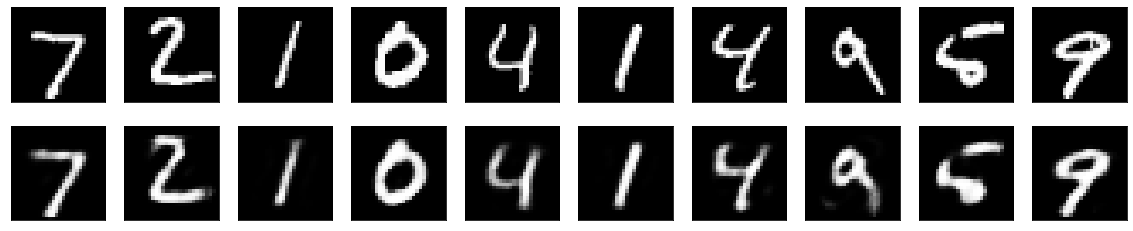

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
